In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import glob
import datetime
import numpy as np
import datetime
from pathlib import Path
import talib as ta
import os

In [2]:
%matplotlib inline

In [3]:
# due working at home and work windows and linux
import platform
import os

if platform.system() == 'Windows' and platform.release() == '10':
    os.chdir(r'L:\andre\Projects\geonumerics\ipython_notebooks\Stocks')
elif platform.system() == 'Windows' and platform.release() == '7':
    os.chdir(r'C:\Data\VBShared\ipython_notebooks\Stocks')
elif platform.system() == 'Linux':
    os.chdir('/home/andre/Projects/stocks')

In [4]:
%load_ext Cython

In [5]:
from Tools import meta5Ibov as meta5_ibov_load
from Tools import backtesting as bet
from Tools.util import progressbar

In [6]:
if platform.system() == 'Windows' and platform.release() == '10':
    meta5_ibov_load.setDataPath(r'L:\andre\Projects\geonumerics\ipython_notebooks\Stocks\data',
                                 r'L:\andre\Projects\geonumerics\ipython_notebooks\Stocks\2016_stocks\2016_2018_M1')
elif platform.system() == 'Windows' and platform.release() == '7':
    meta5_ibov_load.setDataPath(r'C:\Data\VBShared\ipython_notebooks\Stocks\data',
                                 r'C:\Data\VBShared\ipython_notebooks\Stocks\data')
elif platform.system() == 'Linux':
    meta5_ibov_load.setDataPath(r'/home/andre/Projects/stocks/data',
                            r'/home/andre/Projects/stocks/data')

Master data loaded size (minutes):  505242
Symbols loaded:
['PETR4' 'BBDC4' 'VALE3' 'DOL$' 'ITUB4' 'WIN@' 'B3SA3' 'BBAS3' 'ABEV3']


## Default Style Backtesting Engine (Metatrader 5 Arch Idea)

Writing back-testing engine based on Metatrader architecture.  
Easier to port to real Expert Advisor Metatrader 5  

EventSetTimer: to set 1 minute timer  
OnTrade : called everytime an order (from the quee) is executed, an stop is hit or an target is reached.  

The expert advisor will ignore OnTickEvents and  
request data just when a new minute has passed using OnTimer event.  
It will request MqlRates. In that scenario I would receive {time, o, h, l, c, vt, vr}  

For Python back-testing porpouses i will consider only o,h,l,c 1 minute data.  

And due this approximation (not ms tick's) and to mitigate the error on backtesting I will consider allways the  
worst case scenario when placing orders, stop loss, gains based on minute High/Low.

## Backtesting Engine parts on Cython
### Cython is faster than numba 
https://www.ibm.com/developerworks/community/blogs/jfp/entry/A_Comparison_Of_C_Julia_Python_Numba_Cython_Scipy_and_BLAS_on_LU_Factorization?lang=en

In [7]:
masterdf = meta5_ibov_load.loadMeta5Data()

Master data loaded size (minutes):  505242
Symbols loaded:
['PETR4' 'BBDC4' 'VALE3' 'DOL$' 'ITUB4' 'WIN@' 'B3SA3' 'BBAS3' 'ABEV3']
Symbols loaded:
['PETR4' 'BBDC4' 'VALE3' 'DOL$' 'ITUB4' 'WIN@' 'B3SA3' 'BBAS3' 'ABEV3']
percent missing:  0.02973624520526797


In [8]:
def alignDataTime(rates, guess_book):
    # "convert" minutes to relative minutes integers
    rates['i'] = np.arange(0, len(rates), 1)
    # to store begin and end "i" of days indexes
    rates['idayend'] = 0
    rates['idaystart'] = 0
    rates['date'] = rates.index.date.astype(np.datetime64)
    ## Get the the indexes the define each day. Min and Max
    iday_end = rates.groupby(rates['date']).i.max()
    iday_end = iday_end.values
    iday_start = rates.groupby(rates['date']).i.min()
    iday_start = iday_start.values
    for date, group in rates.groupby(rates['date']):
        rates.loc[group.index, 'idayend'] = group.i.max()
        rates.loc[group.index, 'idaystart'] = group.i.min()

    guess_book.set_index('time', inplace=True)
    ## add one day at the beggining and two hours in the end
    prices = rates[guess_book.index[0]-datetime.timedelta(days=1):guess_book.index[-1]+datetime.timedelta(hours=2)].copy()
    # get reference time indexes "i" from rates/prices
    guess_book['i'] = prices.i.loc[guess_book.index] 
    # set to zero at the begging of prices array
    start = prices.i[0] # get the "i" corresponding to the begin of the predictions
    # align everthing to the begin of prices/rates data frame
    # time index "i" will be zero at that
    guess_book.i -= start
    prices.i -= start
    prices.idayend -= start
    prices.idaystart -= start
    # in case we have a day cut in half the begin will be where the prices array started
    # that means 0.
    prices.loc[prices.idaystart < 0, 'idaystart'] = 0 
    return prices, guess_book

In [9]:
petr4_rates = meta5_ibov_load.getSymbol("PETR4")
rates = petr4_rates

In [10]:
cd ../data

/home/andre/Projects/stocks/prototypes


In [11]:
guess_book = pd.read_pickle("PETR4_20180823_all_nobuckets_nopercentiles_no_std_CUDA_NN_EMA120min_shift120_RFy_90_70_percent_pytorch.pickle")

In [12]:
# guess_book['time'] = guess_book['tindex']
# guess_book.drop(columns=['tindex'], inplace=True)

In [13]:
guess_book.head()

,time,terror,verror,direction
0,2013-07-11 12:12:00,0.167969,0.075000,1.0
1,2013-07-11 12:38:00,0.109375,0.066667,1.0
2,2013-07-11 13:07:00,0.277344,0.000000,1.0
3,2013-07-11 13:24:00,0.246094,0.066667,1.0
4,2013-07-11 15:42:00,0.281250,0.066667,1.0


In [14]:
guess_book.drop(columns=['terror', 'verror'], inplace=True)

In [15]:
# removing the 5 minutes delay increases the performance fairly high!
#guess_book.tindex = guess_book.tindex - datetime.timedelta(minutes=4)

In [16]:
rates, guess_book = alignDataTime(rates, guess_book)

In [17]:
guess_book.dropna(inplace=True)

In [18]:
rates.dropna(inplace=True)

### Backup original dataframe with more information for latter analysis

In [19]:
orates = rates.copy()
oguess_book = guess_book.copy()

#### Drop collumns that will not be used

In [20]:
rates.drop(columns=['O', 'C', 'TV', 'RV','date', 'i'], inplace=True)

In [21]:
# input for simulation H, L, idayend, idaystart
ratesv = rates.values.astype(np.float64)
guess_bookv = guess_book.values.astype(np.int32) # get array data only

#ratesv = np.asarray(ratesv, order='C')
#guess_bookv = np.asarray(guess_bookv, order='C')

In [22]:
book_orders_open = np.zeros((guess_book.shape[0], 10), order='C')*np.nan  # very few orders stay here so can be very small
book_orders_closed = np.zeros((guess_book.shape[0], 10), order='C')*np.nan  # all or\ders end-up here so must be big
# *nan to make it easy to multiply by nan after

In [23]:
%matplotlib inline

In [24]:
def Metrics(capital, money, book_closed, istart):
    """
    capital : initial capital
    money progress record : dfmoney
    placed : order_id or index (from closed_book) that were placed
    closed_book : book of closed orders sorted by time
    """
    nclosed = len(book_closed) 
    ntotal = np.sum(np.abs(book_closed[:,7]))
    nfailed = (np.sum(np.abs(book_closed[:,7]))-np.sum(book_closed[:,7]))//2    
    nsucess = ntotal - nfailed    
    finalmoney = (money[-1]-capital)/capital        
    money = (money/capital)-1
    return [nsucess, nfailed, money, finalmoney, istart]

In [25]:
import importlib
importlib.reload(meta5_ibov_load)
importlib.reload(bet)

<module 'Tools.backtesting' from '/home/andre/Projects/stocks/Tools/backtesting.cpython-36m-x86_64-linux-gnu.so'>

In [26]:
%%time
#simperiod = 22*7*60 # simulation period in minutes  one month
# one week is 5*7*60
def scenario(i, guess_bookv, ratesv, book_orders_open, book_orders_closed, simperiod=22*7*60):

    k=2*60 # how many minutes after to close all orders
    capital=50000.
    beg= i # begin4
    input_guess_bookv = guess_bookv[guess_bookv[:,1] < guess_bookv[i,1]+simperiod-1, :][beg:].copy()
    input_ratesv = ratesv[guess_bookv[i, 1]:guess_bookv[i, 1]+simperiod+1+k].copy()
    # allignt start day and end day to zero
    input_ratesv[:, 2:] = np.clip(input_ratesv[:,2:]-guess_bookv[beg,1], 0, np.inf)
    input_guess_bookv[:, 1] -= guess_bookv[beg, 1]

    money, irc, iro = bet.Simulate(input_ratesv, input_guess_bookv, 
                 book_orders_open, book_orders_closed, capital, maxorders=12,
                 norderperdt=2, perdt=15, minprofit=160., expected_var=0.01)
    
    #plt.plot(money, label=str(i))
    #if iro > 0: # nothing wrong we shoudl remove iro
    
    return Metrics(capital, money, book_orders_closed[:irc], i)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [27]:
%%time

metrics = []
metric = scenario(15, guess_bookv, ratesv, book_orders_open, book_orders_closed)
metrics.append(metrics)   

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.66 ms


In [28]:
metric

[62.0, 41.0, array([ 0.      ,  0.      ,  0.      , ..., -0.008924, -0.008924,
        -0.008924]), -0.008923999999999651, 15]

In [29]:
random=False

In [30]:
nwindow=60*22*7

In [31]:
glast = guess_bookv[-1,1] - nwindow + 1 # last possible g value to have the last scenario
# its index would be a search for a value less or equal it (in the array reversed)
#ar = np.asarray(guess_bookv[::-1, 1], order='C') # to call cython
ilast = len(guess_bookv)-bet.argnextLE(guess_bookv[::-1, 1], 0, glast) # the last index for the for is the size minus that index
# so ilast is the number of possible simulations with size nwindow (in time)
print('number of possible scenaricos ', ilast+1) 

number of possible scenaricos  18538


In [32]:
%%time
metrics = []
from joblib import Parallel, delayed

if not random:
    metrics = Parallel(n_jobs=8, verbose=4, backend="threading")(delayed(scenario)(i, guess_bookv.copy(), ratesv.copy(), 
                                         book_orders_open.copy(), book_orders_closed.copy(), nwindow) for i in range(ilast))
else:
    # random samples
    nsize=1000
    metrics = Parallel(n_jobs=8, verbose=4, backend="threading")(
        delayed(scenario)(i, guess_bookv.copy(), ratesv.copy(), book_orders_open.copy(), book_orders_closed.copy(), nwindow)  
        for i in np.random.randint(0, ilast, size=nsize))

[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 376 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 597 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 1185 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 1969 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:   11.8s
[Parallel(n_jobs=8)]: Done 2949 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done 3512 tasks      | elapsed:   16.6s
[Parallel(n_jobs=8)]: Done 4125 tasks      | elapsed:   19.5s
[Parallel(n_jobs=8)]: Done 4786 tasks      | elapsed:   22.4s
[Parallel(n_jobs=8)]: Done 5497 tasks      | elapsed:   25.7s
[Parallel(n_jobs=8)]: Done 6256 tasks      | elapsed:   29.2s
[Parallel(n_jo

CPU times: user 2min 39s, sys: 2.27 s, total: 2min 41s
Wall time: 1min 31s


[Parallel(n_jobs=8)]: Done 18537 out of 18537 | elapsed:  1.5min finished


In [33]:
dfmetrics = pd.DataFrame(metrics, columns=['nsucess', 'nfailure', 'money', 'final', 'start'])
dfmetrics['final'] *= 100 # in percent

from scipy import stats
print('You have {:.0f}'.format(100-stats.percentileofscore(dfmetrics.final.values, 0)), 
      '% of chance of ending up with zero or more money $$')
print('You have {:.0f}'.format(100-stats.percentileofscore(dfmetrics.final.values, 1.0)), 
      '% of chance of ending up with +1.0% or more money $$')

You have 1 % of chance of ending up with zero or more money $$
You have 0 % of chance of ending up with +1.0% or more money $$


In [34]:
def probability_sim(values):
    percentiles = np.percentile(values, [0, 1, 10, 50, 90])
    print('percentiles are ', percentiles)
    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(211);
    ax1.hist(values, bins=100, density=True);
    ax1.bar(percentiles[0], 0.02, width=0.1,  color='r')
    ax1.bar(percentiles[1], 0.02, width=0.1,  color='r')
    ax1.bar(0, 0.02, width=0.1,  color='k')
    ax1.bar(percentiles[2], 0.02, width=0.1,  color='b')
    ax1.bar(percentiles[3], 0.02, width=0.1,  color='b')
    #ax1.set_xlim(percentiles[0], 5)
    ax1.xaxis.set_major_locator(loc)
    ax1.grid()

    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.hist(values, bins=100, density=True, cumulative=True);
    ax2.bar(percentiles[0], 0.2, width=0.1,  color='r')
    ax2.bar(percentiles[1], 0.2, width=0.1,  color='r')
    ax2.bar(0, 0.2, width=0.1,  color='k')
    ax2.bar(percentiles[2], 0.2, width=0.1,  color='b')
    ax2.bar(percentiles[3], 0.2, width=0.1,  color='b')
    ax2.set_xlabel('profit (%)', fontsize=13)
    #ax2.set_xlim(percentiles[0], 5)
    ax2.xaxis.set_major_locator(loc)
    ax2.set_ylabel('cumulative percentage (%)')
    ax2.grid()

percentiles are  [-17.3724 -16.194  -10.7776  -6.4428  -2.8432]


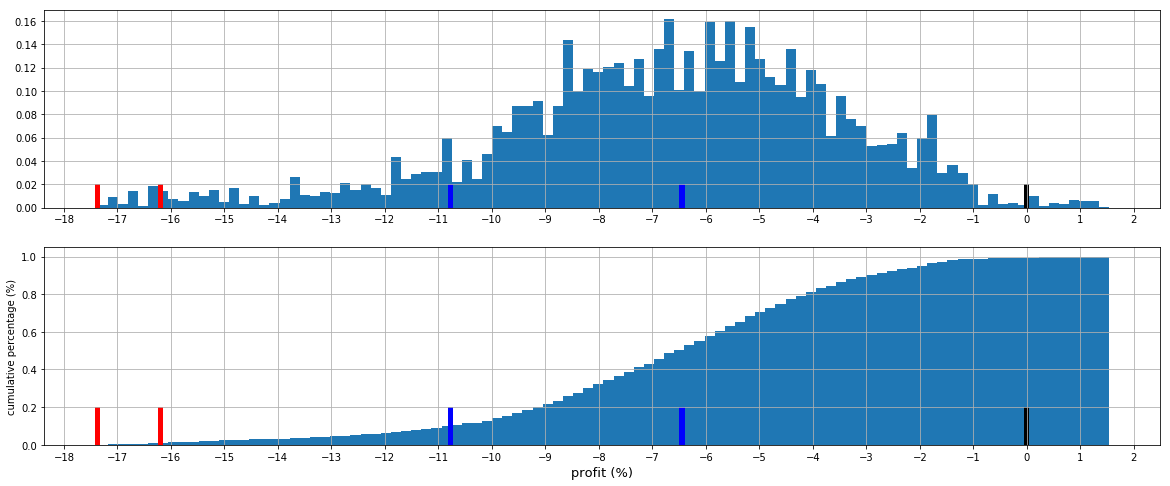

In [35]:
probability_sim(dfmetrics.final.values)

In [36]:
dfmetrics['accuracy'] = dfmetrics.nsucess.values/(dfmetrics.nfailure.values+dfmetrics.nsucess.values)

In [37]:
dfmetrics.loc[dfmetrics.accuracy.isna(), 'accuracy'] = -1

Text(45.125,0.5,'sucess rate of orders average (%)')

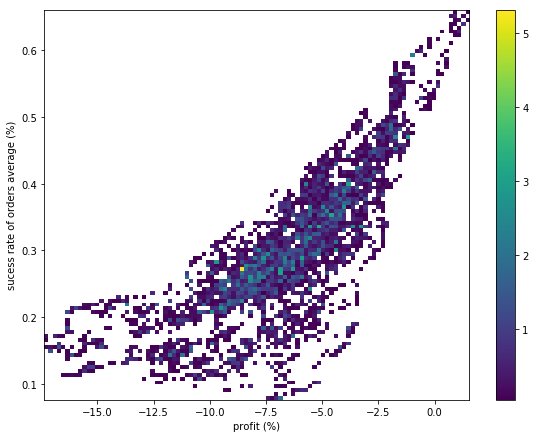

In [38]:
plt.figure(figsize=(8,6))
plt.hist2d(dfmetrics.final.values, dfmetrics.accuracy.values, bins=100, normed=True, cmap='viridis', cmin=0.01);
plt.colorbar()
plt.tight_layout()
plt.xlabel('profit (%)')
plt.ylabel('sucess rate of orders average (%)')

array([ 7.60869565, 10.90909091, 16.32653061, 28.66242038, 43.29896907])

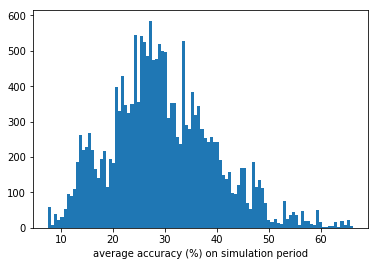

In [39]:
plt.hist(dfmetrics.accuracy*100, bins=100);
plt.xlabel('average accuracy (%) on simulation period');
np.percentile(dfmetrics.accuracy*100, [0, 1, 10, 50, 90])

array([ 2.22727273,  2.68181818,  4.04545455,  5.86363636,  8.        ,
       10.90909091])

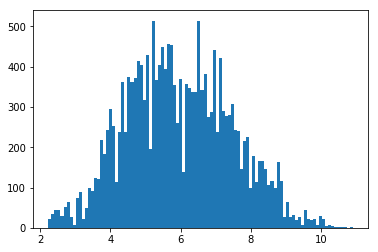

In [40]:
orderday = (dfmetrics.nsucess+dfmetrics.nfailure)/22
plt.hist(orderday, bins=100);
np.percentile(orderday, [0, 1, 10, 50, 90, 100])

Text(0.5,1,'color is sucess rate (%)')

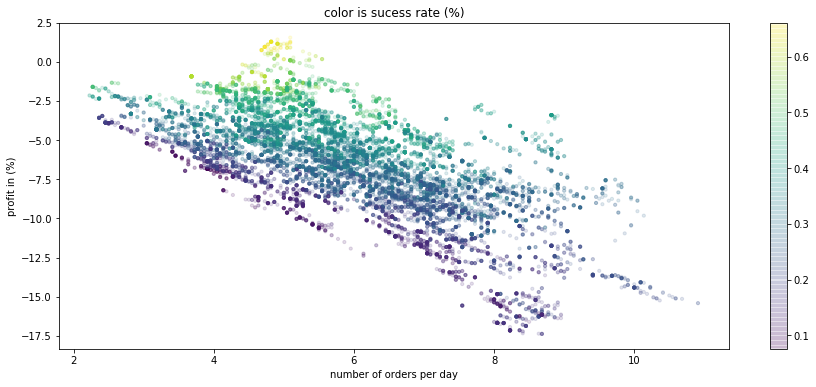

In [41]:
plt.figure(figsize=(15,6))
plt.scatter((dfmetrics.nsucess+dfmetrics.nfailure)/22, dfmetrics.final.values, s=10, alpha=0.15,
            c=dfmetrics.accuracy)
plt.colorbar()
plt.xlabel('number of orders per day')
plt.ylabel('profit in (%)')
plt.title('color is sucess rate (%)')

In [42]:
dfmetrics.columns

Index(['nsucess', 'nfailure', 'money', 'final', 'start', 'accuracy'], dtype='object')

## Maximum Drawdown of capital during period of one month

better thing more about how to analyse money variation ...

In [43]:
metrics

[[49.0,
  41.0,
  array([ 0.      ,  0.      ,  0.      , ..., -0.013864, -0.013864,
         -0.013864]),
  -0.013863999999999505,
  0],
 [49.0,
  41.0,
  array([ 0.      ,  0.      ,  0.      , ..., -0.013864, -0.013864,
         -0.013864]),
  -0.013863999999999505,
  1],
 [52.0,
  45.0,
  array([ 0.     ,  0.     ,  0.     , ..., -0.01698, -0.01698, -0.01698]),
  -0.016979999999999565,
  2],
 [53.0,
  45.0,
  array([ 0.      ,  0.      ,  0.      , ..., -0.016932, -0.016932,
         -0.016932]),
  -0.016931999999999534,
  3],
 [55.0,
  42.0,
  array([ 0.     ,  0.     ,  0.     , ..., -0.01412, -0.01412, -0.01412]),
  -0.014119999999999418,
  4],
 [55.0,
  42.0,
  array([ 0.     ,  0.     ,  0.     , ..., -0.01412, -0.01412, -0.01412]),
  -0.014119999999999418,
  5],
 [55.0,
  42.0,
  array([ 0.     ,  0.     ,  0.     , ..., -0.01412, -0.01412, -0.01412]),
  -0.014119999999999418,
  6],
 [53.0,
  41.0,
  array([ 0.      ,  0.      ,  0.      , ..., -0.013112, -0.013112,
         

In [44]:
moneyvar = np.zeros([0])
for i in range(len(dfmetrics)):
    moneyvar = np.append(moneyvar, dfmetrics.loc[i, 'money'])

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,3)) # min value during simulations percentile [0]
#drawdowns = dfmetrics.apply(lambda x: 100*x[2][0], axis=1).values
plt.hist(moneyvar, bins=100);
np.percentile(moneyvar, [0, 1, 10, 50, 90])

# Average Performance Analysis with Infinit Money

To test average accuracy of algorithm that created the guesses run:
    1. with infinit money

In [45]:
%%time
money, irc, iro = bet.Simulate(np.ascontiguousarray(ratesv), np.ascontiguousarray(guess_bookv), 
                        book_orders_open, book_orders_closed, 50000, maxorders=12,
                 norderperdt=2, perdt=15, minprofit=160, expected_var=0.01)

CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 71.7 ms


In [46]:
ordersbook = {"EP" : 0, "QT" : 1, "DR" : 2, "TP": 3, "SL" : 4, 
              "OT" : 5, "CP" : 6, "SS" : 7, "CT" : 8, "MB" : 9}

In [47]:
dfclosedbook = pd.DataFrame(book_orders_closed, 
                        columns=ordersbook.keys())
dfclosedbook.dropna(inplace=True)

### calculate byday accuracy

In [48]:
rates['i'] = np.arange(len(rates))
dfclosedbook['i'] = dfclosedbook.CT
dfclosedbook = dfclosedbook.merge(rates.reset_index(drop=True), on='i')
dfclosedbook['AS'] = dfclosedbook.SS.apply(lambda x: 1 if x > 0 else 0)
bydayaccuracy = dfclosedbook.groupby('idayend').mean().AS
dfclosedbook.merge(pd.DataFrame(bydayaccuracy), on='idayend');

In [49]:
len(bydayaccuracy)

455

array([0.  , 0.  , 0.  , 0.25, 1.  ])

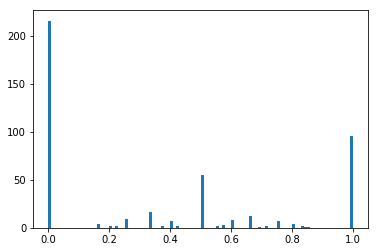

In [50]:
plt.hist(bydayaccuracy, bins=100);
np.percentile(bydayaccuracy, [0, 1, 10, 50, 90])

In [51]:
dfclosedbook.head(1)

,EP,QT,DR,TP,SL,OT,CP,SS,CT,MB,i,H,L,idayend,idaystart,AS
0,14.6,500.0,1.0,15.038,14.454,416.0,14.62,-1.0,537.0,7298.0,537.0,14.63,14.62,646,271,0


In [52]:
import talib as ta

def showSimulation(money, dfclosedbook, rates):
    f, axr = plt.subplots(6, sharex=True, figsize=(18,10))
    f.subplots_adjust(hspace=0)
    axr[0].plot(np.log(money/money[0]))
    axr[0].set_ylabel('money (R$)')
    axr[0].grid()
    plt.figure()
    axr[1].plot(rates.H.values[:len(money)])
    axr[1].plot(rates.L.values[:len(money)])
    axr[1].set_ylabel('price (R$)')
    axr[1].grid()
    plt.figure()
    # when order was executed
    axr[2].plot(dfclosedbook.OT, np.zeros(len(dfclosedbook)), 'xk') # start of arrow
    # when it was closed arrow head
    axr[2].plot(dfclosedbook.CT, dfclosedbook.SS, 'k^')
    # body of arrow
    xs = np.array(list(zip(dfclosedbook.OT, dfclosedbook.CT)))
    ys = np.array(list(zip(np.zeros(len(dfclosedbook)), dfclosedbook.SS)))
    axr[2].plot(xs.T, ys.T, 'b', lw=0.35) 
    axr[2].grid()
    axr[2].set_xlim(0, len(money))
    # regions of better or worse performance
    avgsucess = dfclosedbook.SS.apply(lambda x: 1 if x > 0 else 0)
    avgsucess = np.cumsum(avgsucess)/np.arange(1,len(avgsucess)+1)
    axr[3].plot(dfclosedbook.OT, avgsucess, label='')
    axr[3].set_ylim(np.percentile(avgsucess, [1, 99]))
    axr[3].hlines(np.percentile(avgsucess, 5), 0, len(money), lw=0.5, colors='r', label='P. 5%')
    axr[3].hlines(np.percentile(avgsucess, 95), 0, len(money), lw=0.5, colors='r', label='P. 95%')
    #axr[3].set_title('Average Accuracy')
    axr[3].grid()
    axr[3].legend()
#     axr[3].set_ylabel("Avg. Sucess (30min)")    
#     plt.figure()
     # variance? / volume?
    #axr[4].plot(ta.VAR(rates.LogVolume.values[:len(money)], 600)*ta.EMA(rates.C.values[:len(money)], 600))
    #axr[4].plot(bydayaccuracy.index.values, ta.SMA(bydayaccuracy.values.astype(np.float64), 1), '-', lw=0.5)
    #axr[4].plot(bydayaccuracy.index.values, bydayaccuracy.values, '.k-', lw=0.5, markersize=5
    axr[4].fill_between(bydayaccuracy.index.values, bydayaccuracy.values, lw=0.5)
    axr[4].set_ylabel('day accuracy')
    axr[4].grid()

    axr[5].plot(ta.VAR(rates.LogVolume.values[:len(money)], 720*3))
    axr[5].grid()

In [53]:
dfclosedbook.head(2)

,EP,QT,DR,TP,SL,OT,CP,SS,CT,MB,i,H,L,idayend,idaystart,AS
0,14.60,500.0,1.0,15.0380,14.4540,416.0,14.62,-1.0,537.0,7298.0,537.0,14.63,14.62,646,271,0
1,14.58,500.0,1.0,15.0174,14.4342,439.0,14.66,1.0,560.0,7312.4,560.0,14.69,14.66,646,271,1


In [54]:
# log volume to better analysis
orates['LogVolume'] = np.log2(orates.RV)
orates['TVolume'] = np.log(orates.TV)

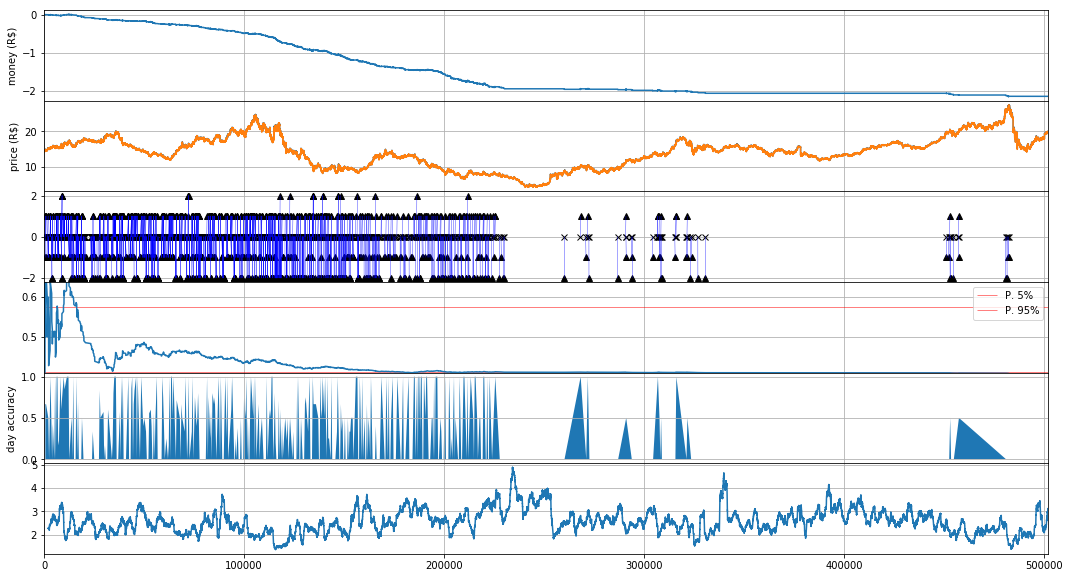

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [55]:
showSimulation(money, dfclosedbook, orates)

In [59]:
tsim = pd.DataFrame(money, columns=['money'])

In [60]:
average_return = 0.04
stdev = 0.02
best_safe = 0.006

In [61]:
#Sharp ratio:
(average_return-best_safe)/0.02

1.7000000000000002

In [62]:
(money[-1]-money[0])/money[0]

-0.8833879999999992

In [63]:
money[-1]

5830.600000000045

In [64]:
np.argmin(money)

482375

In [65]:
money.min()

5778.600000000045

In [66]:
rates['i'] = np.arange(0, len(rates), 1)
rates['di'] = rates['i'] - rates['idaystart'] # minute in the day 
dfclosedbook['life'] = dfclosedbook['CT'] - dfclosedbook['OT']
dfclosedbook['i'] = dfclosedbook['CT']

In [67]:
rates.head(2)

,H,L,idayend,idaystart,i,di
time,,,,,,
2013-07-10 12:12:00,14.42,14.41,270,0,0,0
2013-07-10 12:13:00,14.42,14.40,270,0,1,1


In [68]:
dfclosedbook.i = dfclosedbook.i.astype('int64')
cbook = dfclosedbook.join(rates.reset_index(drop=True), on='i', how='inner', lsuffix='_')
cbook.head(3)

,EP,QT,DR,TP,SL,OT,CP,SS,CT,MB,...,idayend_,idaystart_,AS,life,H,L,idayend,idaystart,i,di
0,14.60,500.0,1.0,15.0380,14.4540,416.0,14.62,-1.0,537.0,7298.0,...,646,271,0,121.0,14.63,14.62,646,271,537,266
1,14.58,500.0,1.0,15.0174,14.4342,439.0,14.66,1.0,560.0,7312.4,...,646,271,1,121.0,14.69,14.66,646,271,560,289
2,14.55,500.0,1.0,14.9865,14.4045,453.0,14.67,1.0,574.0,7313.4,...,646,271,1,121.0,14.70,14.67,646,271,574,303


**Current settings:**

1. Trading sessions have 7 hours : 7x60=420
2. All orders are closed in the end of session  `15 minutes` in general : 420-15 = 405
3. No other is placed 90 minutes before end of session, in general: 420-90 = 330 

Bellow we can that most data in fact have 400 minutes a little less than 7 hours.  
So expire time would be 400-15 = 385  
Some days have 8 hours (480 minutes) also commum on Bovespa past.  
So expire time would be 480-15 = 465

Text(0.5,0,'Day Length (minutes)')

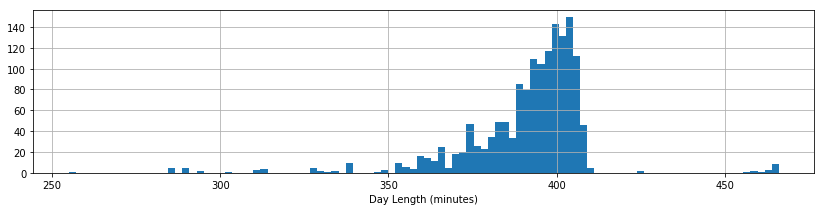

In [69]:
cbook['daylen'] = cbook.idayend.values-cbook.idaystart.values
np.percentile(cbook.daylen.values, [0, 90, ])
plt.figure(figsize=(14,3))
plt.hist(cbook.daylen.values, bins=100);
plt.grid()
plt.xlabel('Day Length (minutes)')

### 2D histogram to analyse when most of the orders and why they get closed.

**Use cmax=50 clip to remove strong effect of expire time of 120 minutes**

Due the fact that:  

No other is placed 90 minutes before end of session, in general: 420-90 = 390  
But all others expire 15 minutes before the end so those last orders last for 90-15: 75 minutes max

Those orders die earlier

/home/andre/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


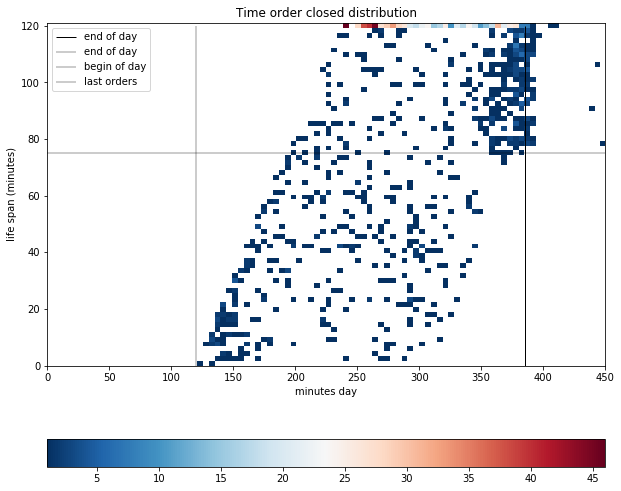

In [70]:
plt.figure(figsize=(10,9))
plt.title('Time order closed distribution')
# 
plt.hist2d(cbook.di, cbook.life, bins=70, cmap='RdBu_r', cmin=1e-5, cmax=60.)
plt.xlim(0,450)
plt.xlabel('minutes day')
plt.ylabel('life span (minutes)')
plt.vlines(385, 0, 120, 'k', lw=1., label='end of day') # expire time due end of day (days of 7 hours)
plt.vlines(465, 0, 120, 'k', lw=0.4, label='end of day') # expire time due end of day (days of 8 hours)
plt.vlines(2*60, 0, 120, 'k', lw=0.4, label='begin of day') # no order allowed before 2*60 minutes of day
plt.hlines(90-15, 0, 450, 'k', lw=0.4, label='last orders') # limit of life last orders
plt.colorbar(orientation='horizontal')
plt.legend(loc='upper left')

### Scatter pĺot like above but with Sucess of Orders

We can see the `385 expire time` mark.

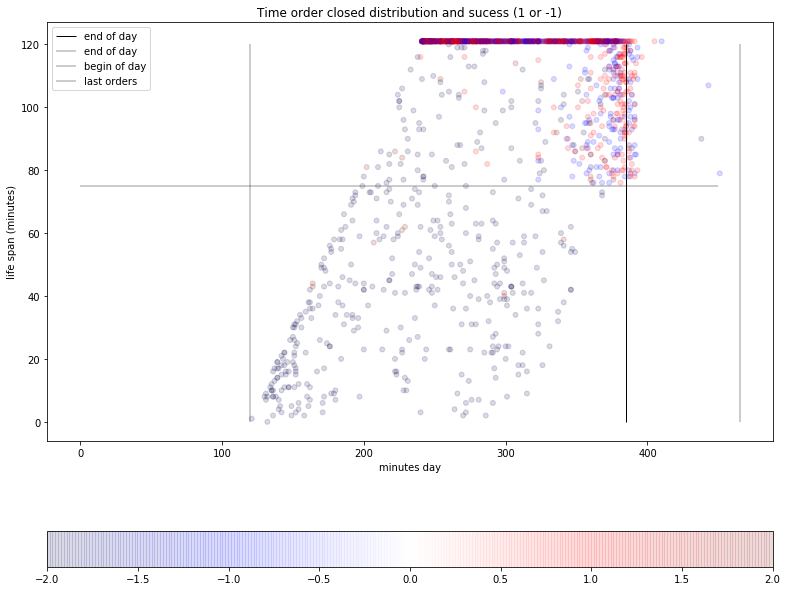

In [73]:
plt.figure(figsize=(13,11))
plt.title('Time order closed distribution and sucess (1 or -1)')
plt.scatter(cbook.di.values, cbook.life.values, c=cbook.SS, s=25, alpha=0.15, cmap='seismic')
plt.xlabel('minutes day')
plt.ylabel('life span (minutes)')
plt.vlines(385, 0, 120, 'k', lw=1., label='end of day') # expire time due end of day (days of 7 hours)
plt.vlines(465, 0, 120, 'k', lw=0.4, label='end of day') # expire time due end of day (days of 8 hours)
plt.vlines(2*60, 0, 120, 'k', lw=0.4, label='begin of day') # no order allowed before 2*60 minutes of day
plt.hlines(90-15, 0, 450, 'k', lw=0.4, label='last orders') # limit of life last orders
plt.colorbar(orientation='horizontal')
plt.legend(loc='upper left')

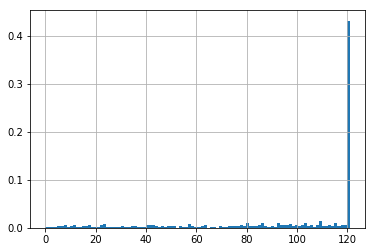

In [74]:
dfclosedbook.life.hist(bins=100, density=True)

In [75]:
dfclosedbook.head(5)

,EP,QT,DR,TP,SL,OT,CP,SS,CT,MB,i,H,L,idayend,idaystart,AS,life
0,14.60,500.0,1.0,15.0380,14.4540,416.0,14.62,-1.0,537.0,7298.0,537,14.63,14.62,646,271,0,121.0
1,14.58,500.0,1.0,15.0174,14.4342,439.0,14.66,1.0,560.0,7312.4,560,14.69,14.66,646,271,1,121.0
2,14.55,500.0,1.0,14.9865,14.4045,453.0,14.67,1.0,574.0,7313.4,574,14.70,14.67,646,271,1,121.0
3,14.59,500.0,-1.0,14.1523,14.7359,872.0,14.58,-1.0,981.0,7288.0,981,14.58,14.57,996,647,0,109.0
4,14.63,500.0,-1.0,14.1911,14.7763,881.0,14.58,1.0,981.0,7325.4,981,14.58,14.57,996,647,1,100.0


In [76]:
# failed orders
ntotal = np.sum(np.abs(dfclosedbook.SS.values))
nfailed = (np.sum(np.abs(dfclosedbook.SS.values))-np.sum(dfclosedbook.SS.values))//2
accuracy = (ntotal-nfailed)/ntotal
print('average accuracy: {:.4f}'.format(accuracy))

average accuracy: 0.3253


## Discussion of Results and Parameter Optimization

1. Average Accuracy (infinit money) - progressive results
    1. Extra tree classifier had an average accuracy of 58% (other data-set and smaller)
    2. Made an experiment making random directional orders accuracy is 22.7%.  
    3. A little better ... 32%.


### Lessons learned


### Time to make scenario simulations, better to analyse performance accuracy than average accuracy